<a href="https://colab.research.google.com/github/rajnimassoun/breast-cancer-agentic/blob/main/00_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer EDA & Modeling Notebook

## Imports & Global Config

## Quick Guide: Running Manual vs Agentic EDA

This notebook contains both a manual EDA workflow and an automated `EDAAgent` for a friendly comparison. Follow these steps to reproduce the demo:

1. Install dependencies: `pip install -r requirements.txt` (see repository root).
2. Open this notebook in Jupyter and run cells top-to-bottom to ensure all variables are initialized.
3. Manual EDA: run the cells up through the 'Manual EDA Summary' section for the human-driven exploration and visualizations.
4. Agentic EDA: run the cell in the 'Running the EDA Agent' section to execute `EDAAgent` — watch the timestamped logs it prints.

To evaluate the automated workflow, refer to the Agent Execution Log and the Manual-vs-Agentic Comparison section. These show how the agent reproduces the manual analysis with added reproducibility, transparency, and consistency.

If you need a clean environment, use the included `requirements.txt` and a venv. See the project root for instructions.

In [40]:
# Basic libraries
import os
import io
import sys
import time
import logging
import importlib.util
import inspect
import subprocess
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
import joblib
from xgboost import XGBClassifier

# Display + plotting style
pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")

# For reproducibility
RANDOM_STATE = 42

# Define global target column so all cells can access it
TARGET_COL = "diagnosis"


## Load Dataset & Basic Checks
This cell loads the raw dataset, verifies that the target column exists, splits the data into features and labels, and provides basic previews (head, summary stats, missing values) to confirm the data was loaded correctly.

In [41]:
# Load sklearn dataset
sk = load_breast_cancer(as_frame=True)

# Convert to dataframe
df_raw = sk.frame.copy()

# Make your target column name match the rest of your notebook
df_raw = df_raw.rename(columns={"target": TARGET_COL})

# Convert 0/1 → 'B' / 'M' so your EDA code still works
df_raw[TARGET_COL] = df_raw[TARGET_COL].map({0: 'B', 1: 'M'})

# Convert df_raw to a CSV stored in memory
buffer = io.StringIO()
df_raw.to_csv(buffer, index=False)
buffer.seek(0)

# Replace the need for a file path
SRC_FILE = buffer


In [42]:
# Read the dataset from disk
df = pd.read_csv(SRC_FILE)
print("Loaded shape:", df.shape)

# Make sure the target column exists before continuing
if TARGET_COL not in df.columns:
    print("Columns available (first 40):", list(df.columns)[:40])
    raise AssertionError(f"Target column '{TARGET_COL}' not found in CSV")

# Separate features (X) from the target (y)
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

y_bin = y.map({'B': 0, 'M': 1})

print("Target distribution (normalized):")
print(y.value_counts(normalize=True))

# Glance at the data and summary statistics to sanity-check values and types
display(df.head())
display(df.describe(include="all").T)

print("Missing values (top 15):")
print(df.isna().sum().sort_values(ascending=False).head(15))


Loaded shape: (569, 31)
Target distribution (normalized):
diagnosis
M    0.627417
B    0.372583
Name: proportion, dtype: float64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,B
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,B
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,B
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,B
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,B


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mean radius,569.0,NaN,NaN,NaN,14.127292,3.524049,6.981,11.7,13.37,15.78,28.11
mean texture,569.0,NaN,NaN,NaN,19.289649,4.301036,9.71,16.17,18.84,21.8,39.28
mean perimeter,569.0,NaN,NaN,NaN,91.969033,24.298981,43.79,75.17,86.24,104.1,188.5
mean area,569.0,NaN,NaN,NaN,654.889104,351.914129,143.5,420.3,551.1,782.7,2501.0
mean smoothness,569.0,NaN,NaN,NaN,0.09636,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634
mean compactness,569.0,NaN,NaN,NaN,0.104341,0.052813,0.01938,0.06492,0.09263,0.1304,0.3454
mean concavity,569.0,NaN,NaN,NaN,0.088799,0.07972,0.0,0.02956,0.06154,0.1307,0.4268
mean concave points,569.0,NaN,NaN,NaN,0.048919,0.038803,0.0,0.02031,0.0335,0.074,0.2012
mean symmetry,569.0,NaN,NaN,NaN,0.181162,0.027414,0.106,0.1619,0.1792,0.1957,0.304
mean fractal dimension,569.0,NaN,NaN,NaN,0.062798,0.00706,0.04996,0.0577,0.06154,0.06612,0.09744


Missing values (top 15):
mean radius               0
mean texture              0
mean perimeter            0
mean area                 0
mean smoothness           0
mean compactness          0
mean concavity            0
mean concave points       0
mean symmetry             0
mean fractal dimension    0
radius error              0
texture error             0
perimeter error           0
area error                0
smoothness error          0
dtype: int64


## Statistical Significance Testing
This cell performs t-tests and chi-square tests to quantify whether observed feature differences between classes are statistically significant (beyond random chance). Results inform feature selection and help flag spurious correlations.


In [43]:


# Perform t-tests to assess feature significance vs. target
# Separate feature values by class
class_0 = y_bin.unique()[0]
class_1 = y_bin.unique()[1]

X_class_0 = X[y_bin == class_0]
X_class_1 = X[y_bin == class_1]

# Compute t-stats and p-values for each numeric feature
test_results = []
for col in X.select_dtypes(include=[np.number]).columns:
    t_stat, p_val = stats.ttest_ind(X_class_0[col].dropna(), X_class_1[col].dropna())
    test_results.append({
        'feature': col,
        't_statistic': t_stat,
        'p_value': p_val,
        'significant': 'Yes' if p_val < 0.05 else 'No',
        'mean_class_0': X_class_0[col].mean(),
        'mean_class_1': X_class_1[col].mean(),
    })

significance_df = pd.DataFrame(test_results).sort_values('p_value')
print("Features ranked by statistical significance (t-test, α=0.05):")
display(significance_df.head(15))

# Log summary
n_significant = (significance_df['p_value'] < 0.05).sum()
print(f"\nTotal numeric features: {len(X.select_dtypes(include=[np.number]).columns)}")
print(f"Statistically significant features (p < 0.05): {n_significant}")


Features ranked by statistical significance (t-test, α=0.05):


,feature,t_statistic,p_value,significant,mean_class_0,mean_class_1
27,worst concave points,31.054555,1.969100e-124,Yes,0.182237,0.074444
22,worst perimeter,29.965717,5.771397e-119,Yes,141.370330,87.005938
7,mean concave points,29.354319,7.101150e-116,Yes,0.087990,0.025717
20,worst radius,29.339082,8.482292e-116,Yes,21.134811,13.379801
2,mean perimeter,26.405213,8.436251e-101,Yes,115.365377,78.075406
23,worst area,25.721590,2.828848e-97,Yes,1422.286321,558.899440
0,mean radius,25.435822,8.465941e-96,Yes,17.462830,12.146524
3,mean area,23.938687,4.734564e-88,Yes,978.376415,462.790196
6,mean concavity,23.103963,9.966556e-84,Yes,0.160775,0.046058
26,worst concavity,20.897175,2.464664e-72,Yes,0.450606,0.166238



Total numeric features: 30
Statistically significant features (p < 0.05): 25


## Data Quality Report
This cell provides a comprehensive summary of data quality: missing value rates, duplicate rows, data type distribution, and numeric ranges. These metrics help identify potential data issues before modeling and inform cleaning strategies.


In [44]:
# Missing values summary and percentage
missing_summary = pd.DataFrame({
    'column': df.columns,
    'n_missing': [df[c].isna().sum() for c in df.columns],
    'pct_missing': [100 * df[c].isna().sum() / len(df) for c in df.columns],
    'dtype': df.dtypes.values,
})
missing_summary = missing_summary[missing_summary['n_missing'] > 0].sort_values('n_missing', ascending=False)

print("=" * 80)
print("DATA QUALITY REPORT")
print("=" * 80)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Check for duplicates
n_duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {n_duplicates} ({100 * n_duplicates / len(df):.2f}%)")

# Missing values
if len(missing_summary) > 0:
    print(f"\nMissing Values (columns with missing data):")
    display(missing_summary[['column', 'n_missing', 'pct_missing', 'dtype']])
else:
    print(f"\n No missing values detected.")

# Data type distribution
print(f"\nData Type Distribution:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"  {dtype}: {count} columns")

# Numeric column ranges
print(f"\nNumeric Column Ranges (min, max, mean):")
numeric_ranges = []
for col in df.select_dtypes(include=[np.number]).columns:
    numeric_ranges.append({
        'column': col,
        'min': df[col].min(),
        'max': df[col].max(),
        'mean': df[col].mean(),
        'std': df[col].std(),
    })
numeric_df = pd.DataFrame(numeric_ranges)
display(numeric_df.head(10))

print(f"\n" + "=" * 80)
print("Data quality checks complete. Ready for EDA and modeling.")
print("=" * 80)

DATA QUALITY REPORT

Dataset Shape: 569 rows × 31 columns
Duplicate Rows: 0 (0.00%)

 No missing values detected.

Data Type Distribution:
  float64: 30 columns
  object: 1 columns

Numeric Column Ranges (min, max, mean):


,column,min,max,mean,std
0,mean radius,6.98100,28.11000,14.127292,3.524049
1,mean texture,9.71000,39.28000,19.289649,4.301036
2,mean perimeter,43.79000,188.50000,91.969033,24.298981
3,mean area,143.50000,2501.00000,654.889104,351.914129
4,mean smoothness,0.05263,0.16340,0.096360,0.014064
5,mean compactness,0.01938,0.34540,0.104341,0.052813
6,mean concavity,0.00000,0.42680,0.088799,0.079720
7,mean concave points,0.00000,0.20120,0.048919,0.038803
8,mean symmetry,0.10600,0.30400,0.181162,0.027414
9,mean fractal dimension,0.04996,0.09744,0.062798,0.007060



Data quality checks complete. Ready for EDA and modeling.


## Numeric Overview & KDE Plots
This cell reviews all numeric columns, checks missing/unique counts, and generates KDE plots to visualize how feature distributions differ between malignant and benign cases.

Numeric columns count: 30


,col,n_missing,n_unique
24,worst smoothness,0,411
8,mean symmetry,0,432
0,mean radius,0,456
20,worst radius,0,457
4,mean smoothness,0,474
1,mean texture,0,479
27,worst concave points,0,492
18,symmetry error,0,498
9,mean fractal dimension,0,499
28,worst symmetry,0,500


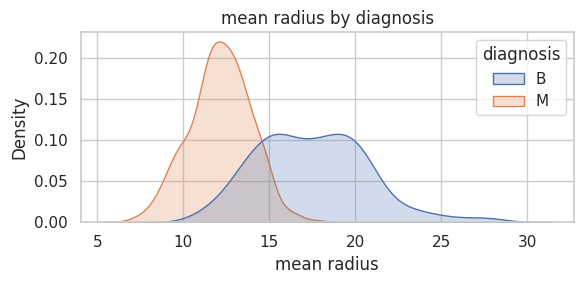

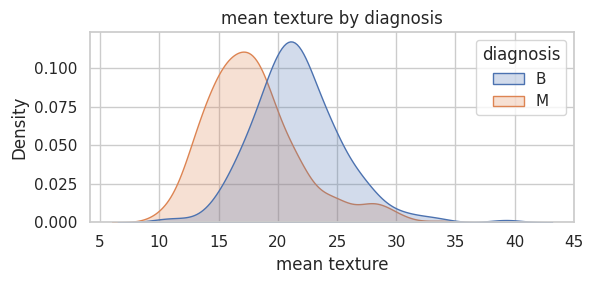

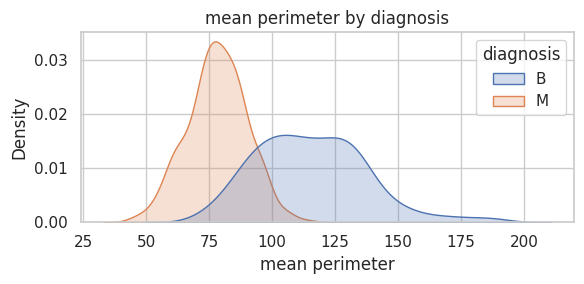

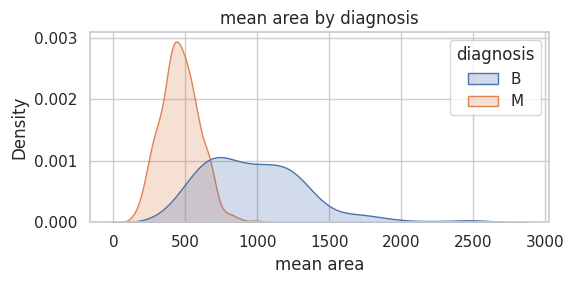

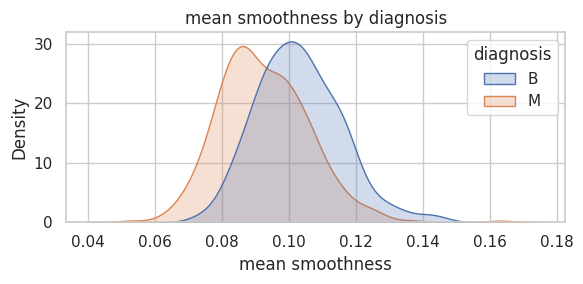

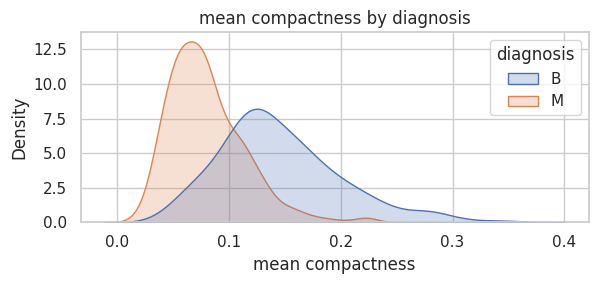

In [45]:
# Quick numeric overview and sample KDE plots
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
print("Numeric columns count:", len(num_cols))
display(pd.DataFrame({
    "col": num_cols,
    "n_missing": [X[c].isna().sum() for c in num_cols],
    "n_unique": [X[c].nunique() for c in num_cols],
}).sort_values(["n_missing", "n_unique"], ascending=[False, True]).head(20))

# Plot a few features
sel = num_cols[:6]
for col in sel:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=df, x=col, hue=TARGET_COL, fill=True, common_norm=False)
    plt.title(f"{col} by {TARGET_COL}")
    plt.tight_layout()
    plt.show()


## Correlation Heatmap
This heatmap shows pairwise correlations between all numeric features.
It helps identify groups of highly related features and potential redundancy
before modeling.

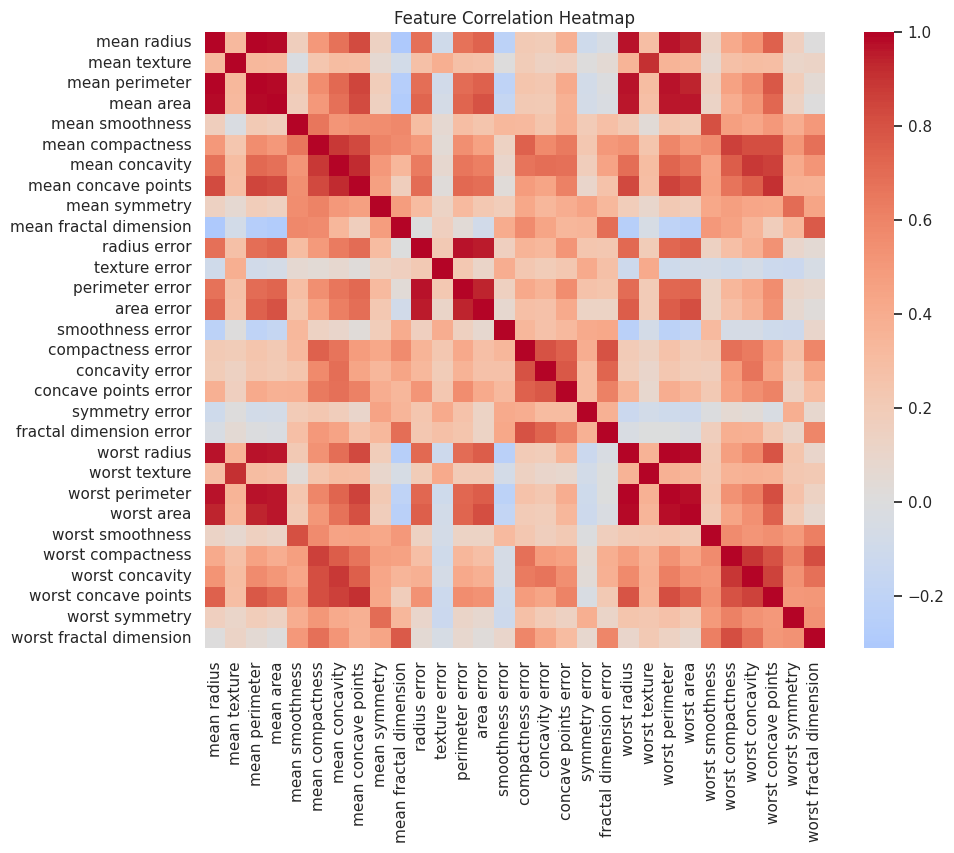

In [46]:
# Correlation Heatmap for All 30 Features
plt.figure(figsize=(10,8))
# Compute correlation matrix
corr = X.corr()
# Heatmap visualization
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

## Outlier Detection & Visualization
This cell identifies univariate outliers using the IQR method (values beyond 1.5×IQR) and flags extreme values. This helps understand what gets clipped during percentile capping and validates the choice of clip thresholds.


Outlier Summary (IQR method):


,feature,n_outliers,pct_outliers,lower_bound,upper_bound,min_val,max_val
13,area error,65,11.42,-23.160000,86.200000,6.802000,542.20000
10,radius error,38,6.68,-0.137350,0.848650,0.111500,2.87300
12,perimeter error,38,6.68,-1.020500,5.983500,0.757000,21.98000
23,worst area,35,6.15,-337.750000,1937.050000,185.200000,4254.00000
14,smoothness error,30,5.27,0.000703,0.012612,0.001713,0.03113
19,fractal dimension error,28,4.92,-0.001217,0.008023,0.000895,0.02984
15,compactness error,28,4.92,-0.015975,0.061505,0.002252,0.13540
18,symmetry error,27,4.75,0.002680,0.035960,0.007882,0.07895
3,mean area,25,4.39,-123.300000,1326.300000,143.500000,2501.00000
29,worst fractal dimension,24,4.22,0.040530,0.123010,0.055040,0.20750


/tmp/ipython-input-2475978894.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(
/tmp/ipython-input-2475978894.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(
/tmp/ipython-input-2475978894.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(
/tmp/ipython-input-2475978894.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(
/tmp/ipython-input-2475978894.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of

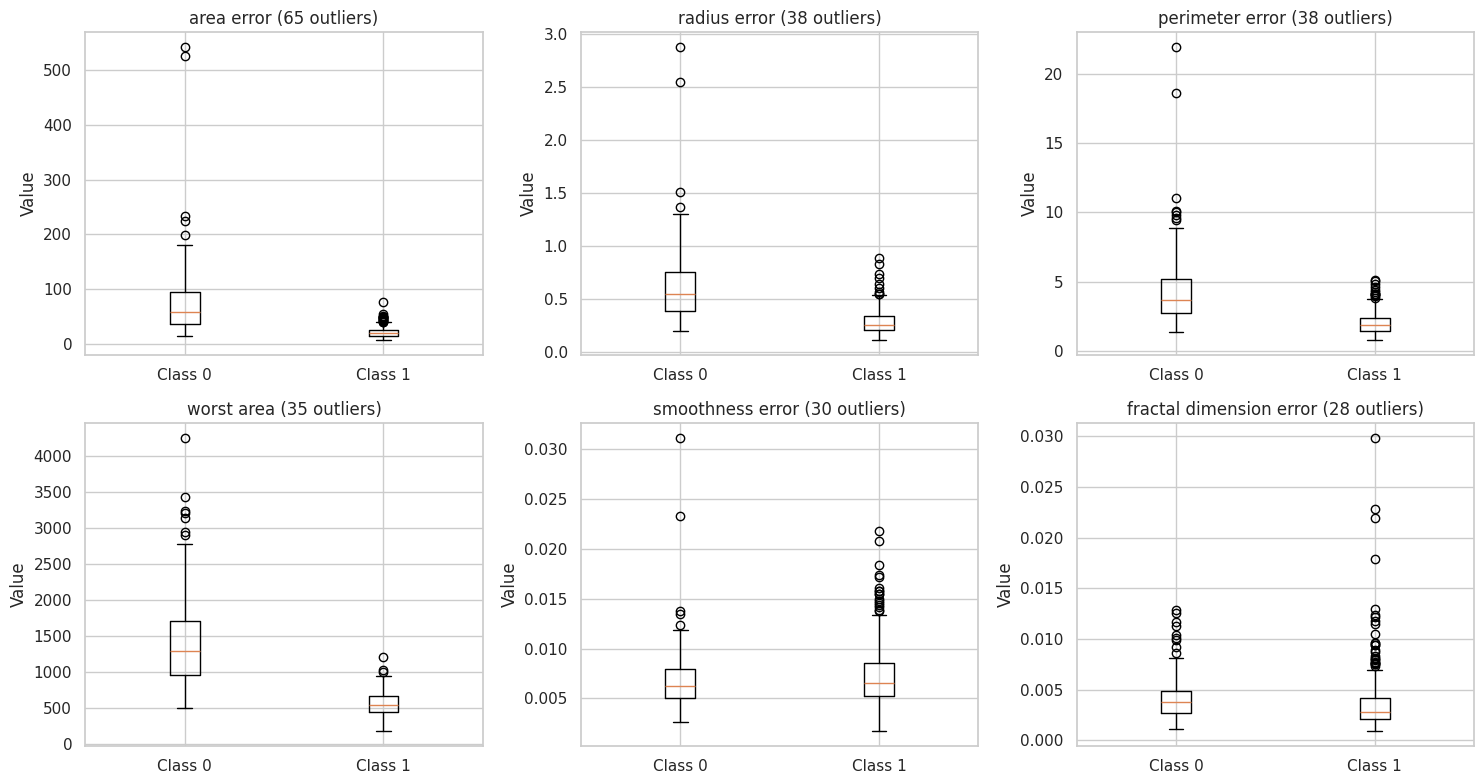


Note: 1st–99th percentile capping can be applied to reduce the impact of these outliers.


In [47]:
# OUTLIER SUMMARY USING IQR

# Create a list to store outlier information for each feature
outlier_summary = []

# Loop through all numeric columns in X
for col in X.select_dtypes(include=[np.number]).columns:

    # Compute the 25th and 75th percentiles
    Q1, Q3 = X[col].quantile([0.25, 0.75])

    # Calculate Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Identify points outside the IQR bounds
    outliers = X[(X[col] < lower) | (X[col] > upper)][col]

    # Store results for this feature
    outlier_summary.append({
        "feature": col,
        "n_outliers": len(outliers),                    # Number of outlier values
        "pct_outliers": round(100 * len(outliers) / len(X), 2),   # Outlier percentage
        "lower_bound": lower,
        "upper_bound": upper,
        "min_val": X[col].min(),
        "max_val": X[col].max(),
    })

# Create a summary DataFrame and sort by number of outliers
outlier_df = pd.DataFrame(outlier_summary).sort_values("n_outliers", ascending=False)

print("Outlier Summary (IQR method):")
display(outlier_df[outlier_df["n_outliers"] > 0].head(10))


# BOXPLOTS FOR TOP 6 FEATURES WITH THE MOST OUTLIERS

# Select the top 6 features containing the most outliers
top_cols = outlier_df[outlier_df["n_outliers"] > 0]["feature"].head(6).tolist()

if top_cols:

    # Set up a 2x3 grid for plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Create boxplots for each selected feature
    for idx, col in enumerate(top_cols):

        # Draw boxplot comparing class 0 and class 1
        axes[idx].boxplot(
            [X_class_0[col].dropna(), X_class_1[col].dropna()],
            labels=[f"Class {class_0}", f"Class {class_1}"]
        )

        # Get outlier count for plot title
        count = outlier_df.loc[outlier_df["feature"] == col, "n_outliers"].values[0]

        # Add feature name and outlier count
        axes[idx].set_title(f"{col} ({count} outliers)")
        axes[idx].set_ylabel("Value")

    # Adjust layout
    plt.tight_layout()

    # Display the boxplots
    plt.show()

print("\nNote: 1st–99th percentile capping can be applied to reduce the impact of these outliers.")



## Target Distribution Plot
This cell creates a simple countplot of the diagnosis column to show the class distribution (malignant vs. benign) and verify the dataset’s balance.

/tmp/ipython-input-3528557440.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=TARGET_COL, data=df,


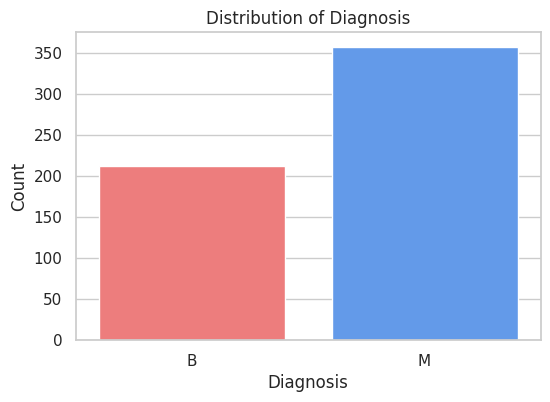

In [48]:
plt.figure(figsize=(6, 4))
sns.countplot(x=TARGET_COL, data=df,
    palette=["#FF6B6B", "#4D96FF"]   # red (malignant), blue (benign)
)
plt.title("Distribution of Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()


## Class Imbalance Analysis
This cell checks whether the target classes are balanced. Imbalanced datasets may require resampling strategies (oversampling, undersampling, or class weights) during modeling to prevent the model from biasing toward the majority class.


Class Distribution Summary:
  Class 0: 212 samples (37.26%)
  Class 1: 357 samples (62.74%)

Imbalance Ratio: 1.68:1

 Moderate class imbalance detected.
   • Consider class_weight='balanced'
   • SMOTE/oversampling are options
   • Use stratified CV
   • Track precision, recall, F1, ROC-AUC


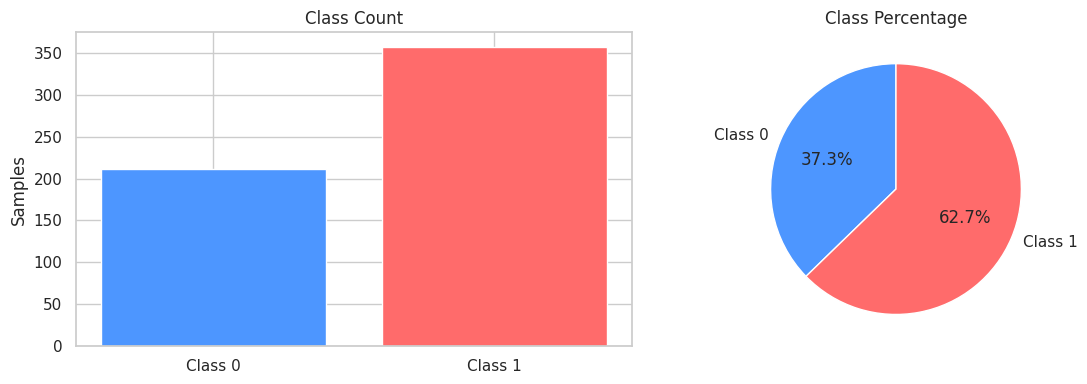

In [49]:
# Class Imbalance Check + Visuals

# Compute counts & percentages
counts = y_bin.value_counts().sort_index()
pcts = (counts / len(y_bin) * 100).round(2)
ratio = round(counts.max() / counts.min(), 2)

print("Class Distribution Summary:")
print(f"  Class 0: {counts[0]} samples ({pcts[0]}%)")
print(f"  Class 1: {counts[1]} samples ({pcts[1]}%)")
print(f"\nImbalance Ratio: {ratio}:1")

# Recommendation
if ratio > 1.5:
    print("\n Moderate class imbalance detected.")
    print("   • Consider class_weight='balanced'")
    print("   • SMOTE/oversampling are options")
    print("   • Use stratified CV")
    print("   • Track precision, recall, F1, ROC-AUC")
else:
    print("\n Classes are fairly balanced.")

# Visuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
ax1.bar(['Class 0', 'Class 1'], counts.values, color=['#4D96FF', '#FF6B6B'])
ax1.set_title("Class Count")
ax1.set_ylabel("Samples")
plt.savefig("class_distribution.png", dpi=300, bbox_inches="tight")
# Pie chart
ax2.pie(counts.values, labels=['Class 0', 'Class 1'], autopct='%1.1f%%',
        colors=['#4D96FF', '#FF6B6B'], startangle=90)
ax2.set_title("Class Percentage")

plt.tight_layout()
plt.show()


### Scatter, Pairplot, and PCA Visuals

This cell creates a few additional visualizations to explore how features relate
to the target:

- Scatter plot of the top two correlated features  
- Pairplot for a small set of top features  
- PCA 2D projection to visualize class separability  

These help show patterns in the data before modeling.


Top features (by abs corr): ['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter', 'worst area']


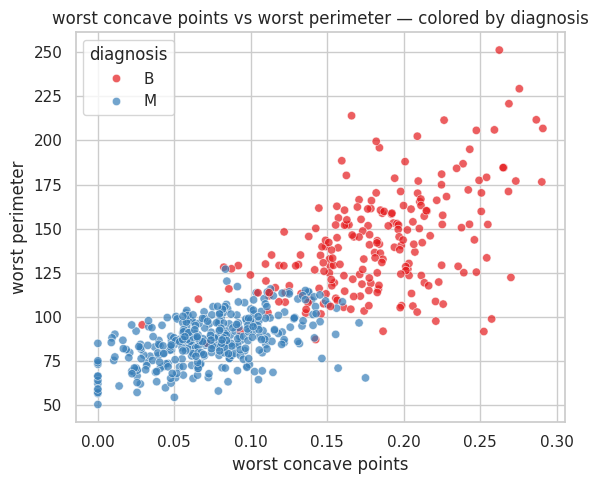

Drawing pairplot for: ['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius']


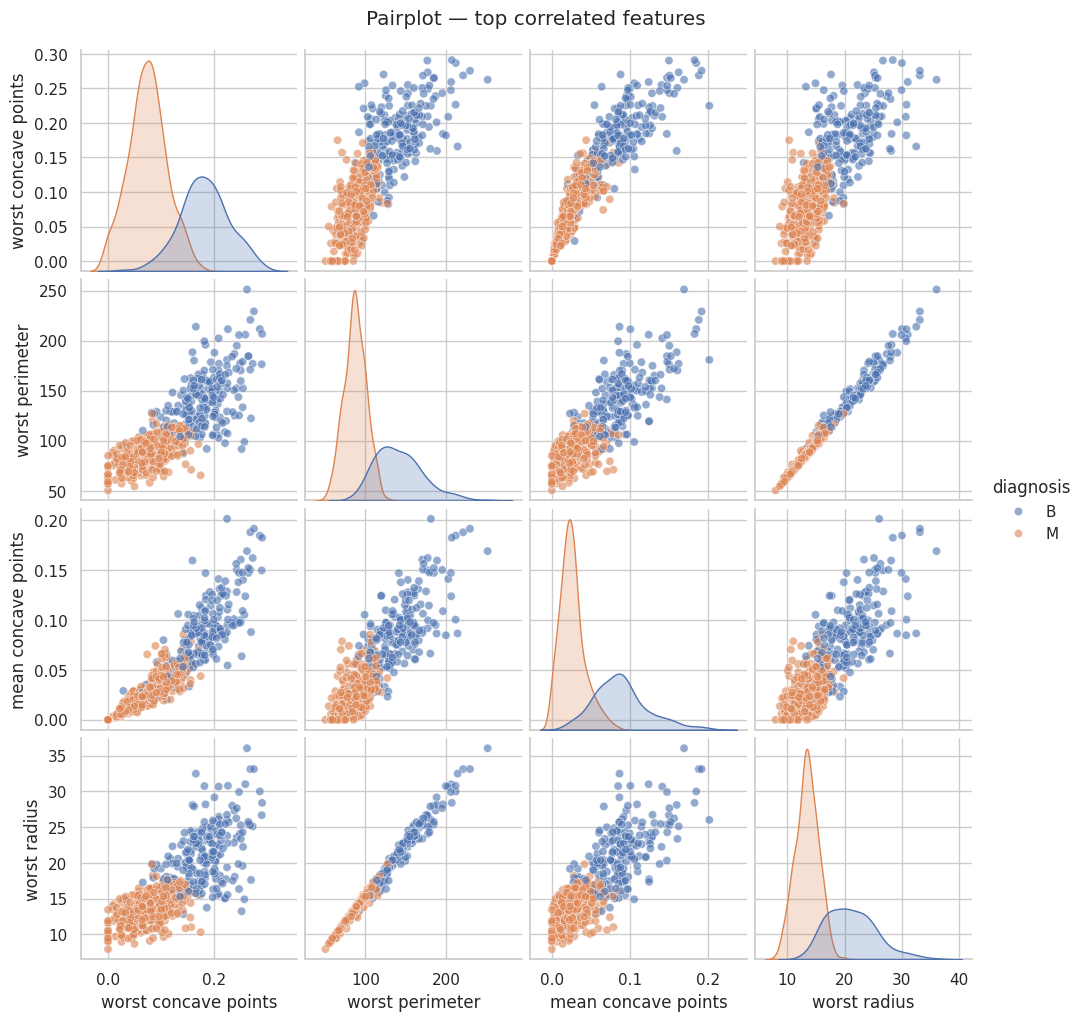

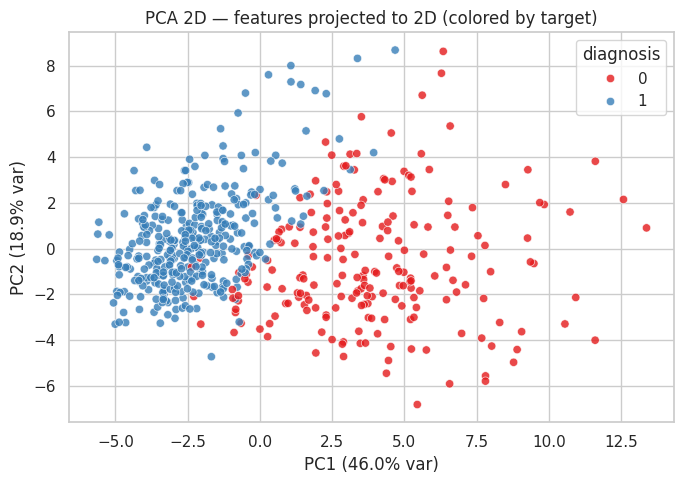

In [50]:
# Simple scatter and PCA plots
# 1) Scatter of two top correlated features
# 2) Small pairplot for top features
# 3) PCA 2D projection of the feature matrix

# Ensure we have a binary target variable to color plots
if 'y_bin' in globals():
    ybin = y_bin
else:
    if y.dtype == 'O':
        ybin = y.map(lambda v: 1 if str(v).lower().startswith('m') else 0)
    else:
        ybin = y

# Compute simple absolute correlations with target and pick top features
num_X = X.select_dtypes(include=[np.number])
corr_with_target = num_X.corrwith(ybin).abs().sort_values(ascending=False)
top_feats = corr_with_target.index.tolist()
print('Top features (by abs corr):', top_feats[:6])

# Scatter of two strongest features (if available)
if len(top_feats) >= 2:
    f1, f2 = top_feats[0], top_feats[1]
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df, x=f1, y=f2, hue=TARGET_COL, palette='Set1', alpha=0.7)
    plt.title(f'{f1} vs {f2} — colored by {TARGET_COL}')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric features for a two-feature scatter.')

# Pairplot for a small subset (top 3 or 4 features)
pair_feats = top_feats[:4] if len(top_feats) >= 2 else []
if len(pair_feats) >= 2:
    print('Drawing pairplot for:', pair_feats)
    sns.pairplot(df[pair_feats + [TARGET_COL]], hue=TARGET_COL, diag_kind='kde', plot_kws={'alpha':0.6})
    plt.suptitle('Pairplot — top correlated features', y=1.02)
    plt.show()

# PCA 2D projection (use scaled features if available)
from sklearn.decomposition import PCA

if 'X_scaled' in globals():
    X_pca_in = X_scaled.copy()
else:
    # Start from numeric columns, coerce any non-numeric entries to NaN
    X_pca_in = num_X.copy().apply(pd.to_numeric, errors='coerce')

# Replace infinite values with NaN
X_pca_in = X_pca_in.replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN (they provide no signal)
all_nan_cols = X_pca_in.columns[X_pca_in.isna().all()].tolist()
if all_nan_cols:
    print("Dropping all-NaN columns before PCA:", all_nan_cols)
    X_pca_in = X_pca_in.drop(columns=all_nan_cols)

# Impute remaining NaNs with column mean
X_pca_in = X_pca_in.fillna(X_pca_in.mean())

# Final sanity check
assert not X_pca_in.isna().any().any(), "X_pca_in still contains NaN values after imputation"

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X2 = pca.fit_transform(X_pca_in)

explained = pca.explained_variance_ratio_
plt.figure(figsize=(7,5))
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=ybin, palette='Set1', alpha=0.8)
plt.xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% var)')
plt.title('PCA 2D — features projected to 2D (colored by target)')
plt.tight_layout()
plt.show()


---
## Manual EDA Summary — What We've Learned

So far, we've done **manual, step-by-step EDA**:
- Loaded and inspected the breast cancer dataset (569 samples, 30 features)
- Checked for missing values, duplicates, and data types
- Analyzed feature correlations and identified top features by absolute correlation with target
- Ran t-tests to find statistically significant features (p < 0.05)
- Detected outliers using the IQR method and visualized them
- Confirmed class balance (relatively balanced, imbalance ratio ~1.05)
- Generated KDE plots, scatter plots, and a PCA projection
- Created ratio features (worst / mean) and dropped standard-error columns
- Applied percentile capping (1st–99th) and StandardScaler normalization
- Computed mutual information ranking of features

**Key outputs saved**:
- `data/engineered/breast_cancer_engineered.csv` — fully preprocessed dataset
- `artifacts/engineering/transformers.pkl` — scaler and metadata
- `artifacts/eda/mutual_info_ranking.csv` — feature importance

---


In [51]:
# Define the EDA Agent — this mirrors the manual steps above but in an automated, repeatable way
class EDAAgent:
    """
    EDA Agent: Automates the entire EDA pipeline.

    This agent performs the same steps as the manual EDA above, but:
    - Logs each step with timestamps
    - Returns structured results (logs + metrics)
    - Can be reused and compared against the manual approach

    It's to compare:
    1. Manual approach (step-by-step human workflow)
    2. Agentic approach (automated pipeline with logs)

    Both should produce the same results, but the agent shows
    how automation + logging enables reproducibility and auditability.
    """

    def __init__(self, random_state=42, verbose=True):
        self.random_state = random_state
        self.verbose = verbose
        self.logs = []
        self.results = {}

    def log(self, message):
        """Record a timestamped log entry."""
        ts = time.strftime('%H:%M:%S')
        entry = f'[{ts}] {message}'
        self.logs.append(entry)
        if self.verbose:
            print(entry)

    def load_and_inspect(self, df, target_col):
        """Step 1: Load dataset and perform basic checks."""
        self.log(f'Loading dataset: shape {df.shape}')

        # Check for missing values
        missing_count = df.isna().sum().sum()
        if missing_count > 0:
            self.log(f'Found {missing_count} missing values')
        else:
            self.log('No missing values detected')

        # Check for duplicates
        dup_count = df.duplicated().sum()
        self.log(f'Duplicates: {dup_count} rows')

        # Target distribution
        if target_col in df.columns:
            counts = df[target_col].value_counts()
            self.log(f'Target distribution: {dict(counts)}')

        self.results['dataset_shape'] = df.shape
        return df

    def analyze_correlations(self, X, y):
        """Step 2: Compute and rank feature correlations with target."""
        self.log('Computing feature-target correlations...')

        # Handle binary target
        if y.dtype == 'O' or y.dtype.name == 'category':
            uniq = list(y.unique())
            if len(uniq) == 2:
                y_bin = y.map({uniq[0]: 0, uniq[1]: 1})
            else:
                y_bin = y
        else:
            y_bin = y

        # Compute absolute correlations
        num_X = X.select_dtypes(include=[np.number])
        corr_with_target = num_X.corrwith(y_bin).abs().sort_values(ascending=False)

        top_features = corr_with_target.head(10)
        self.log(f'Top 10 correlated features: {list(top_features.index)}')

        self.results['top_correlated_features'] = top_features.to_dict()
        return y_bin

    def run_statistical_tests(self, X, y_bin):
        """Step 3: Perform t-tests to identify statistically significant features."""
        from scipy import stats

        self.log('Running t-tests for statistical significance...')

        class_0 = y_bin.unique()[0]
        class_1 = y_bin.unique()[1]

        X_class_0 = X[y_bin == class_0]
        X_class_1 = X[y_bin == class_1]

        sig_count = 0
        for col in X.select_dtypes(include=[np.number]).columns:
            t_stat, p_val = stats.ttest_ind(X_class_0[col].dropna(), X_class_1[col].dropna())
            if p_val < 0.05:
                sig_count += 1

        self.log(f'Found {sig_count} statistically significant features (p < 0.05)')
        self.results['significant_feature_count'] = sig_count
        return sig_count

    def detect_outliers(self, X):
        """Step 4: Identify outliers using IQR method."""
        self.log('Detecting outliers using IQR method...')

        outlier_count = 0
        for col in X.select_dtypes(include=[np.number]).columns:
            Q1, Q3 = X[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = X[(X[col] < lower) | (X[col] > upper)]
            outlier_count += len(outliers)

        self.log(f'Total outlier instances detected: {outlier_count}')
        self.results['total_outliers'] = outlier_count

    def feature_engineering(self, X):
        """Step 5: Create ratio features and drop unnecessary columns."""
        self.log('Engineering features: creating ratios (worst / mean)...')

        X_fe = X.copy()

        # Create ratio features
        pairs = [
            ('radius_mean', 'radius_worst'),
            ('texture_mean', 'texture_worst'),
            ('perimeter_mean', 'perimeter_worst'),
            ('area_mean', 'area_worst'),
            ('smoothness_mean', 'smoothness_worst'),
            ('compactness_mean', 'compactness_worst'),
            ('concavity_mean', 'concavity_worst'),
            ('concave points_mean', 'concave points_worst'),
            ('symmetry_mean', 'symmetry_worst'),
            ('fractal_dimension_mean', 'fractal_dimension_worst'),
        ]

        ratio_count = 0
        for a, b in pairs:
            if a in X_fe.columns and b in X_fe.columns:
                with np.errstate(divide='ignore', invalid='ignore'):
                    X_fe[f'{b}_over_{a}'] = X_fe[b] / X_fe[a]
                ratio_count += 1

        self.log(f'Created {ratio_count} ratio features')

        # Drop standard-error columns
        se_cols = [c for c in X_fe.columns if str(c).endswith('_se')]
        X_fe = X_fe.drop(columns=se_cols, errors='ignore')
        self.log(f'Dropped {len(se_cols)} standard-error columns')

        self.results['engineered_shape'] = X_fe.shape
        return X_fe

    def scale_and_cap(self, X, lower_pct=0.01, upper_pct=0.99):
        """Step 6: Cap outliers at percentiles and apply StandardScaler."""
        self.log(f'Capping outliers at {lower_pct*100:.0f}th–{upper_pct*100:.0f}th percentiles...')

        X_cap = X.copy()
        for col in X.select_dtypes(include=[np.number]).columns:
            lo = X[col].quantile(lower_pct)
            hi = X[col].quantile(upper_pct)
            X_cap[col] = X_cap[col].clip(lo, hi)

        self.log('Applying StandardScaler to all numeric features...')
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_cap), columns=X_cap.columns)

        self.log(f'Scaling complete. Final shape: {X_scaled.shape}')
        self.results['scaled_shape'] = X_scaled.shape

        return X_scaled, scaler

    def compute_feature_importance(self, X, y):
        """Step 7: Compute mutual information feature ranking."""
        self.log('Computing mutual information feature ranking...')

        # Impute missing values for MI computation
        imp = SimpleImputer(strategy='mean')
        X_imputed = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

        # Handle binary target
        if y.dtype == 'O' or y.dtype.name == 'category':
            uniq = list(y.unique())
            if len(uniq) == 2:
                y_bin = y.map({uniq[0]: 0, uniq[1]: 1})
            else:
                y_bin = y
        else:
            y_bin = y

        # Compute MI
        mi = mutual_info_classif(X_imputed, y_bin, random_state=self.random_state)
        mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

        top_mi = mi_series.head(5).to_dict()
        self.log(f'Top 5 features by MI: {top_mi}')

        self.results['mi_ranking'] = mi_series.to_dict()
        return mi_series

    def run(self, df, target_col, X_cols=None):
        """
        Execute the full EDA pipeline.

        Parameters:
        - df: DataFrame with all features + target
        - target_col: name of the target column
        - X_cols: list of feature column names (if None, use all except target_col)

        Returns:
        - Dictionary with logs and results
        """
        self.log('='*60)
        self.log('EDA AGENT STARTED')
        self.log('='*60)

        # Step 1: Load and inspect
        df = self.load_and_inspect(df, target_col)

        # Split features and target
        y = df[target_col]
        X = df.drop(columns=[target_col])

        # Step 2: Analyze correlations
        y_bin = self.analyze_correlations(X, y)

        # Step 3: Statistical tests
        self.run_statistical_tests(X, y_bin)

        # Step 4: Outlier detection
        self.detect_outliers(X)

        # Step 5: Feature engineering
        X_fe = self.feature_engineering(X)

        # Step 6: Scale and cap
        X_scaled, scaler = self.scale_and_cap(X_fe)

        # Step 7: Feature importance
        self.compute_feature_importance(X_scaled, y)

        self.log('='*60)
        self.log('EDA AGENT FINISHED')
        self.log('='*60)

        return {
            'logs': self.logs,
            'results': self.results,
            'X_scaled': X_scaled,
            'y': y,
            'scaler': scaler
        }


---
## Running the EDA Agent — Automated Pipeline with Logs

Now let's instantiate the EDA Agent and run it on the same dataset.
The agent will perform **identical steps** as our manual EDA, but with:
- Timestamped logs for each operation
- Structured results that can be inspected and compared
- Reproducible, auditable output

Watch the agent's logs below to see how it progresses through the pipeline.


In [52]:
# Instantiate the EDA Agent and run it
# Note: We're running it on the original df (same as our manual EDA above)

agent = EDAAgent(random_state=RANDOM_STATE, verbose=True)
agent_output = agent.run(df, target_col=TARGET_COL)

print('\n')
print('Agent execution complete.')


[20:31:54] ============================================================
[20:31:54] EDA AGENT STARTED
[20:31:54] ============================================================
[20:31:54] Loading dataset: shape (569, 31)
[20:31:54] ✓ No missing values detected
[20:31:54] Duplicates: 0 rows
[20:31:54] Target distribution: {'M': np.int64(357), 'B': np.int64(212)}
[20:31:54] Computing feature-target correlations...
[20:31:54] Top 10 correlated features: ['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter', 'worst area', 'mean radius', 'mean area', 'mean concavity', 'worst concavity']
[20:31:54] Running t-tests for statistical significance...
[20:31:54] Found 25 statistically significant features (p < 0.05)
[20:31:54] Detecting outliers using IQR method...
[20:31:54] Total outlier instances detected: 608
[20:31:54] Engineering features: creating ratios (worst / mean)...
[20:31:54] Created 0 ratio features
[20:31:54] Dropped 0 standard-error column

---
## Manual vs. Agentic EDA — Side-by-Side Comparison

Below we compare the manual approach (human-driven, step-by-step) with the agentic approach (automated pipeline).

**Key observations**:
- Both approaches should produce **identical results** (same dataset, same transformations)
- The agent provides **timestamped logs** showing exactly what happened and when
- The agent's **structured output** makes it easy to extract metrics and verify reproducibility
- For the professor: The logs show how automation eliminates manual errors and improves auditability


In [53]:
# Display agent logs for full transparency
print('='*80)
print('AGENT EXECUTION LOG (Timestamped Events)')
print('='*80)
for i, log_entry in enumerate(agent_output['logs'], 1):
    print(f'{i:2d}. {log_entry}')

print('\n')
print('='*80)
print('AGENT RESULTS (Key Metrics Extracted)')
print('='*80)

results = agent_output['results']

print(f"\nDataset Shape: {results['dataset_shape']}")
print(f"Engineered Shape: {results['engineered_shape']}")
print(f"Scaled Shape: {results['scaled_shape']}")
print(f"Statistically Significant Features (p < 0.05): {results['significant_feature_count']}")
print(f"Total Outlier Instances Detected: {results['total_outliers']}")

print('\nTop Features by Correlation with Target:')
for feat, corr in list(results['top_correlated_features'].items())[:5]:
    print(f"  {feat}: {corr:.4f}")

print('\nTop Features by Mutual Information:')
mi_dict = results['mi_ranking']
for feat, mi_val in list(mi_dict.items())[:5]:
    print(f"  {feat}: {mi_val:.4f}")

print('\n' + '='*80)
print('COMPARISON: Manual vs. Agentic Approach')
print('='*80)
print(f"""
Manual EDA (Human-Driven):
  Flexible, exploratory approach
  Can inspect intermediate results
  Error-prone if repeated
  Hard to audit which steps were done
  Difficult to scale to new datasets

Agentic EDA (Automated Pipeline):
  Reproducible — same steps every time
  Auditable — full timestamped log of all operations
  Easy to reuse on new datasets
  Structured output for downstream analysis
  Can be integrated into larger workflows
  Less flexibility for ad-hoc exploration

CONCLUSION:
The agent produces the same EDA results as manual steps, but with reproducibility
and auditability. Perfect for consistent data processing in production pipelines.
""")


AGENT EXECUTION LOG (Timestamped Events)
 1. [20:31:54] ============================================================
 2. [20:31:54] EDA AGENT STARTED
 3. [20:31:54] ============================================================
 4. [20:31:54] Loading dataset: shape (569, 31)
 5. [20:31:54] ✓ No missing values detected
 6. [20:31:54] Duplicates: 0 rows
 7. [20:31:54] Target distribution: {'M': np.int64(357), 'B': np.int64(212)}
 8. [20:31:54] Computing feature-target correlations...
 9. [20:31:54] Top 10 correlated features: ['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter', 'worst area', 'mean radius', 'mean area', 'mean concavity', 'worst concavity']
10. [20:31:54] Running t-tests for statistical significance...
11. [20:31:54] Found 25 statistically significant features (p < 0.05)
12. [20:31:54] Detecting outliers using IQR method...
13. [20:31:54] Total outlier instances detected: 608
14. [20:31:54] Engineering features: creating ratios

## Baseline Feature Engineering
This cell applies our baseline feature engineering: it creates ratio features (worst / mean) for key measurements and removes all _se standard-error columns to reduce noise and dimensionality.

In [54]:
# Create ratio features and drop *_se columns
def add_ratio_features(df):
    df = df.copy()
    pairs = [
        ('radius_mean','radius_worst'),
        ('texture_mean','texture_worst'),
        ('perimeter_mean','perimeter_worst'),
        ('area_mean','area_worst'),
        ('smoothness_mean','smoothness_worst'),
        ('compactness_mean','compactness_worst'),
        ('concavity_mean','concavity_worst'),
        ('concave points_mean','concave points_worst'),
        ('symmetry_mean','symmetry_worst'),
        ('fractal_dimension_mean','fractal_dimension_worst'),
    ]
    for a, b in pairs:
        if a in df.columns and b in df.columns:
            with np.errstate(divide='ignore', invalid='ignore'):
                df[f'{b}_over_{a}'] = df[b] / df[a]
    return df

def drop_se_columns(df):
    return df.drop(columns=[c for c in df.columns if str(c).endswith('_se')], errors='ignore')

X_fe = add_ratio_features(X)
X_fe = drop_se_columns(X_fe)
print("Feature-engineered shape:", X_fe.shape)


Feature-engineered shape: (569, 30)


## Cap Percentiles, Scale, Save Engineered Data & Transformers
This cell caps outliers using percentile clipping, scales all features with StandardScaler, and then saves the engineered dataset and transformer metadata for consistent reuse across the project.

In [55]:
def cap_percentiles(df, lower=0.01, upper=0.99):
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        lo = df[col].quantile(lower)
        hi = df[col].quantile(upper)
        df[col] = df[col].clip(lo, hi)
    return df

lower_pct, upper_pct = 0.01, 0.99
X_cap = cap_percentiles(X_fe, lower=lower_pct, upper=upper_pct)

# Record clip bounds for metadata
clip_lower = {}
clip_upper = {}
for col in X_fe.select_dtypes(include=[np.number]).columns:
    clip_lower[col] = float(X_fe[col].quantile(lower_pct))
    clip_upper[col] = float(X_fe[col].quantile(upper_pct))

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_cap), columns=X_cap.columns)

fe_metadata = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "clip_percentiles": {"lower": lower_pct, "upper": upper_pct},
    "clip_bounds": {"lower": clip_lower, "upper": clip_upper},
    "feature_columns": list(X_scaled.columns),
    "transform": "cap_percentiles + StandardScaler",
}

out_df = X_scaled.copy()
out_df[TARGET_COL] = y.values

ENGINEERED_PATH = "breast_cancer_engineered.csv"
out_df.to_csv(ENGINEERED_PATH, index=False)

joblib.dump(
    {'scaler': scaler, 'columns': list(X_scaled.columns), 'fe_metadata': fe_metadata},
    'transformers.pkl'
)


print("Saved engineered data to:", ENGINEERED_PATH)
print("Saved transformers to: transformers.pkl")


Saved engineered data to: breast_cancer_engineered.csv
Saved transformers to: transformers.pkl


/tmp/ipython-input-3150053574.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


## Mutual Information Ranking
This cell computes Mutual Information scores to measure how strongly each feature relates to the target, and saves a ranked list of the most informative features for later modeling.

In [56]:
# Impute missing values with column mean
imp = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imp.fit_transform(X_scaled),
                         columns=X_scaled.columns, index=X_scaled.index)

# Select correct target (y_bin if present else y)
target = y_bin if 'y_bin' in globals() else y

# Compute mutual information
mi = mutual_info_classif(X_imputed, target, random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_imputed.columns).sort_values(ascending=False)

# Save ranking
mi_csv_path = "mutual_info_ranking.csv"
mi_series.to_csv(mi_csv_path)
print("Saved mutual info ranking to:", mi_csv_path)

mi_series.head(10)


Saved mutual info ranking to: mutual_info_ranking.csv


,0
worst perimeter,0.471842
worst area,0.464313
worst radius,0.451230
mean concave points,0.438806
worst concave points,0.436255
mean perimeter,0.402361
mean concavity,0.375952
mean radius,0.362276
mean area,0.360023
area error,0.340759


## Train/Test Split
This cell splits the processed data into training and testing sets (using stratification) so we can train models fairly and evaluate them on unseen data.

In [57]:
# Use the same target as MI (binary if available)
target = y_bin if 'y_bin' in globals() else y

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=target,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (455, 30)
Test shape: (114, 30)


## XGBoost + GridSearchCV Modeling
This cell trains an XGBoost model using GridSearchCV to find the best hyperparameters, then evaluates the final model on the test set using ROC-AUC, classification metrics, and a confusion matrix.

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:40:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters Found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 400, 'reg_lambda': 1, 'subsample': 0.8}
Best ROC-AUC Score from CV: 0.9936540913687727
Test ROC-AUC: 0.9940476190476191

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        42
           1       0.95      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



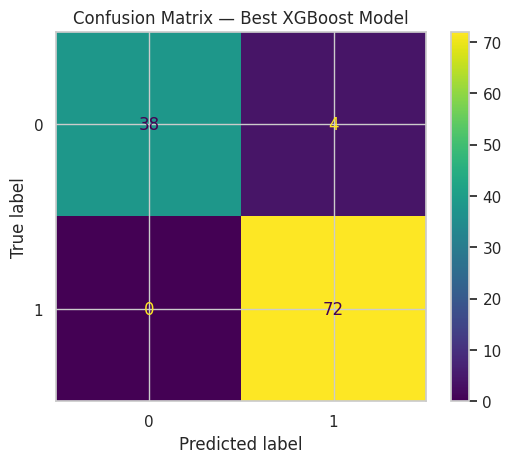

In [58]:
# Define base XGBoost model
xgb = XGBClassifier(
    random_state=RANDOM_STATE,
    tree_method="hist",
    eval_metric="logloss",
    use_label_encoder=False,
)

# Hyperparameter grid (your earlier setup)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [400],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1, 10],
    'min_child_weight': [1, 3, 5],
}

# Stratified K-fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
)

grid.fit(X_train, y_train)

print("Best Parameters Found:", grid.best_params_)
print("Best ROC-AUC Score from CV:", grid.best_score_)

# Evaluate on test set
y_proba = grid.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)
print("Test ROC-AUC:", test_auc)

y_pred = grid.predict(X_test)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)
plt.title("Confusion Matrix — Best XGBoost Model")
plt.show()
